In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy # To copy objects

# --- Imports for Portfolio Optimization (Part 2) ---
import itertools # To create combinations
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting 

import riskfolio as rf
import ta
import scipy
print(scipy.__version__)

# --- Global Settings ---
sns.set_theme(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

1.16.1


## PART I: PORTFOLIO OPTIMIZATION
Diversification

Choose the most optimal stock out of the portfolio

### 1. Gather data

In [22]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM']
n = len(tickers)
risk_free_rate = 0.02

start_date = "2020-01-01"
end_date = "2025-10-31"
split_date = "2024-12-31" 

def get_data( tickers, start_date, end_date):
    try:
        print(f"Getting data for {n} tickers: {tickers}")
        print(f"Total period: {start_date} to {end_date}")
        data = yf.download(tickers, start=start_date, end=end_date)['Close']
        if data.empty:
            raise ValueError("No data fetched.")
        
        print("Data loading completed.")
        return data
    except Exception as e:
        print(f"ERROR: {e}")
        return None

all_data = get_data(tickers, start_date, end_date)
train_data = all_data.loc[:split_date]
test_data = all_data.loc[split_date:]

print(f"Train Set: {train_data.index.min().date()} -> {train_data.index.max().date()} ({len(train_data)} days)")
print(f"Test Set:  {test_data.index.min().date()} -> {test_data.index.max().date()} ({len(test_data)} days)")

[                       0%                       ]

Getting data for 8 tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM']
Total period: 2020-01-01 to 2025-10-31


[*********************100%***********************]  8 of 8 completed

Data loading completed.
Train Set: 2020-01-02 -> 2024-12-31 (1258 days)
Test Set:  2024-12-31 -> 2025-10-30 (209 days)


### 2. Return and risk calculation

In [23]:
return_train = expected_returns.mean_historical_return(train_data, frequency=252)
cov_train = risk_models.sample_cov(train_data, frequency=252)

### 3. Sharpe ratio calculation

Static Weights found (n-MaxSharpe):
AAPL     0.0000
AMZN     0.0000
GOOGL    0.0000
JPM      0.0000
META     0.0000
MSFT     0.0000
NVDA     0.8311
TSLA     0.1689
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 83.8%
Annual volatility: 51.1%
Sharpe Ratio: 1.60


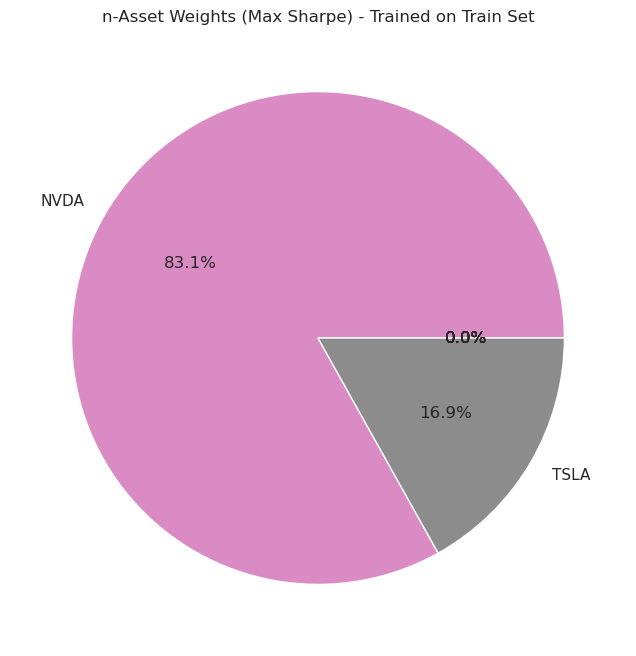

In [24]:
ef_sharpe_n = EfficientFrontier(return_train, cov_train, weight_bounds=(0, 1))

# 2. Optimize
weights_sharpe_n = ef_sharpe_n.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights_sharpe_n = ef_sharpe_n.clean_weights()

# 3. Print results
print("Static Weights found (n-MaxSharpe):")
print(pd.Series(cleaned_weights_sharpe_n))
print("\nPerformance (In-Sample, on Train Set):")
ef_sharpe_n.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 4. Visualize (Pie Chart)
fig, ax = plt.subplots(figsize=(8, 8))
pd.Series(cleaned_weights_sharpe_n).plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    title='n-Asset Weights (Max Sharpe) - Trained on Train Set'
)
ax.set_ylabel('')
plt.show()

### 4. Volatility

Static Weights found (n-MinVol):
AAPL     0.18544
AMZN     0.14419
GOOGL    0.11989
JPM      0.37982
META     0.00000
MSFT     0.17065
NVDA     0.00000
TSLA     0.00000
dtype: float64

Performance (In-Sample, on Train Set):
Expected annual return: 19.9%
Annual volatility: 25.4%
Sharpe Ratio: 0.70


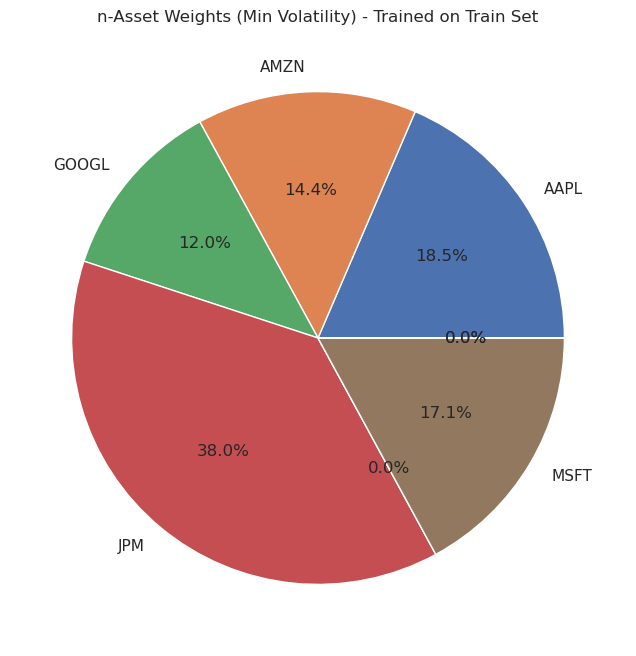

In [25]:
ef_vol_n = EfficientFrontier(return_train, cov_train, weight_bounds=(0, 1))

# 2. Optimize
weights_vol_n = ef_vol_n.min_volatility()
cleaned_weights_vol_n = ef_vol_n.clean_weights()

# 3. Print results
print("Static Weights found (n-MinVol):")
print(pd.Series(cleaned_weights_vol_n))
print("\nPerformance (In-Sample, on Train Set):")
ef_vol_n.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

# 4. Visualize (Pie Chart)
fig, ax = plt.subplots(figsize=(8, 8))
pd.Series(cleaned_weights_vol_n).plot.pie(
    ax=ax, 
    autopct='%1.1f%%', 
    title='n-Asset Weights (Min Volatility) - Trained on Train Set'
)
ax.set_ylabel('')
plt.show()

### 5. Efficient frontier

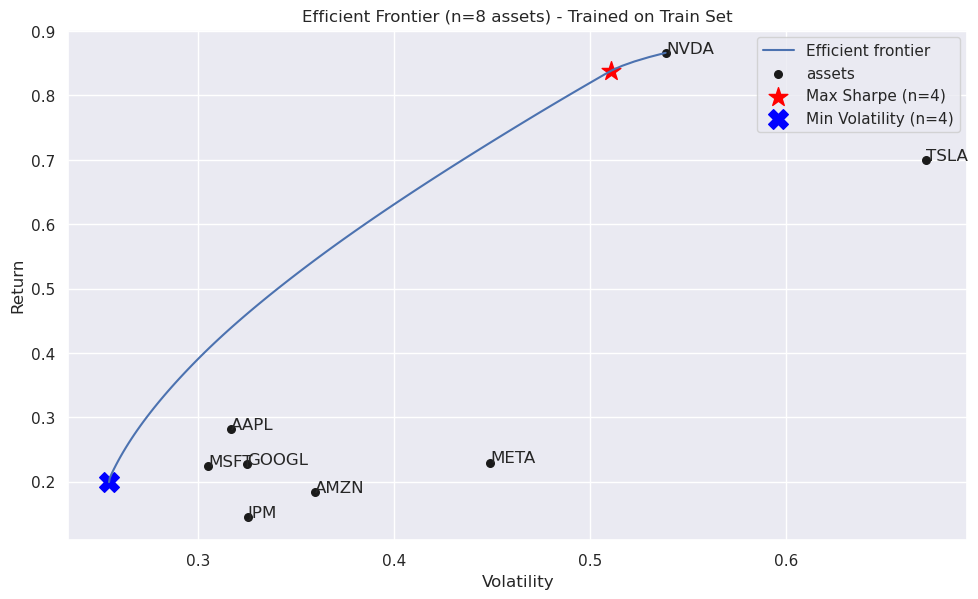

In [26]:
ef_plot_n = EfficientFrontier(return_train, cov_train, weight_bounds=(0, 1))

fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot_n, ax=ax, show_assets=True, show_tickers=True)

# Add the points we found (from 2.3 and 2.4)
ax.scatter(ef_sharpe_n.portfolio_performance()[1], ef_sharpe_n.portfolio_performance()[0], marker="*", s=200, c="red", label="Max Sharpe (n=4)")
ax.scatter(ef_vol_n.portfolio_performance()[1], ef_vol_n.portfolio_performance()[0], marker="X", s=200, c="blue", label="Min Volatility (n=4)")

ax.set_title(f"Efficient Frontier (n={n} assets) - Trained on Train Set")
ax.legend()
plt.show()

### 6. Optimize max sharpe

In [27]:
## USING RISKFOLIO-LIBRARY
port = rf.Portfolio(returns=train_data.pct_change().dropna())
port.assets_stats(method_mu='hist', method_cov='hist')

weights = port.optimization(model='Classic',
                            rm='MV',
                            obj='Sharpe',
                            hist=True)
weights.T

,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,TSLA
weights,2.171679e-09,4.151316e-10,8.956210e-10,0.04801,6.354549e-10,5.599394e-10,0.676452,0.275538


### 7. Optimize min volatility

### 8. Test

In [28]:
ef_vol_n = EfficientFrontier(return_train, cov_train, weight_bounds=(0, 1))

weights_vol_n = ef_vol_n.min_volatility()
cleaned_weights_vol_n = ef_vol_n.clean_weights()

Riskfolio estimated mu (with freq=252):
       AAPL      AMZN     GOOGL       JPM      META      MSFT     NVDA      TSLA
0  0.001182  0.000923  0.001022  0.000746  0.001225  0.000988  0.00305  0.002997

Riskfolio Min Volatility Weights:
            AAPL      AMZN     GOOGL      JPM          META      MSFT          NVDA          TSLA
weights  0.18544  0.144195  0.119905  0.37981  5.519095e-09  0.170649  1.857266e-09  2.536813e-09

Expected Return: 0.1%
Volatility: 1.6%
Sharpe Ratio: -1.19


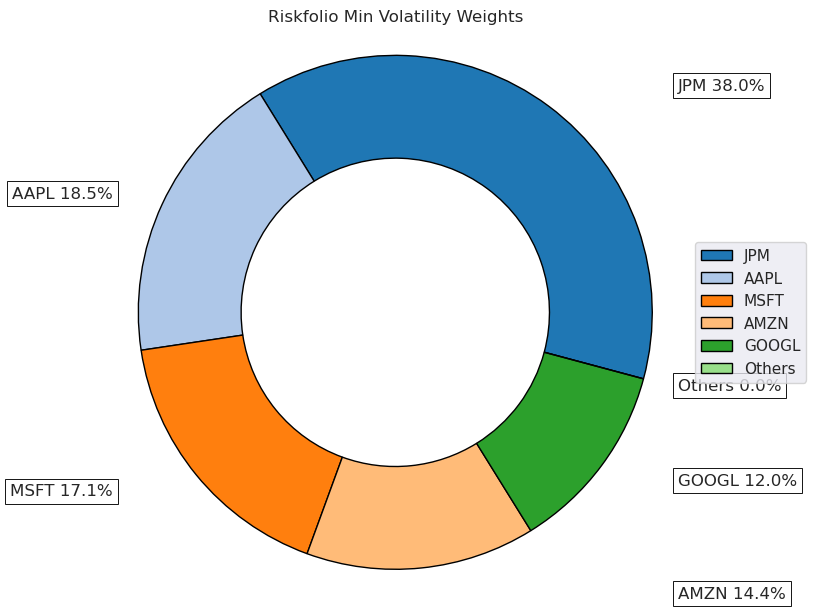

In [29]:
# AI imported
## USING RISKFOLIO-LIBRARY for Min Volatility
returns_rf = train_data.pct_change().dropna()

port_min_vol = rf.Portfolio(returns=returns_rf)
port_min_vol.assets_stats(method_mu='hist', method_cov='hist')

print("Riskfolio estimated mu (with freq=252):")
print(port_min_vol.mu)

weights_min_vol = port_min_vol.optimization(model='Classic',
                                             rm='MV',
                                             obj='MinRisk',
                                             rf=risk_free_rate)
print("\nRiskfolio Min Volatility Weights:")
print(weights_min_vol.T)

# Performance calculation
w = weights_min_vol.values.flatten()
exp_return = float(port_min_vol.mu.dot(w))
volatility = float(np.sqrt(w.T @ port_min_vol.cov @ w))
sharpe = (exp_return - risk_free_rate) / volatility if volatility > 0 else np.nan

print(f"\nExpected Return: {exp_return:.1%}")
print(f"Volatility: {volatility:.1%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

# Plot pie
try:
    rf.plot_pie(weights_min_vol, title='Riskfolio Min Volatility Weights')
except:
    weights_min_vol.T.plot.pie(figsize=(6,6), autopct='%1.1f%%', title='Riskfolio Min Volatility Weights')

Riskfolio estimated mu (with freq=252):
       AAPL      AMZN     GOOGL       JPM      META      MSFT     NVDA      TSLA
0  0.001182  0.000923  0.001022  0.000746  0.001225  0.000988  0.00305  0.002997

Riskfolio Max Sharpe Weights:
                 AAPL          AMZN         GOOGL      JPM          META          MSFT      NVDA      TSLA
weights  2.171679e-09  4.151316e-10  8.956210e-10  0.04801  6.354549e-10  5.599394e-10  0.676452  0.275538

Expected Return: 0.3%
Volatility: 3.1%
Sharpe Ratio: -0.56


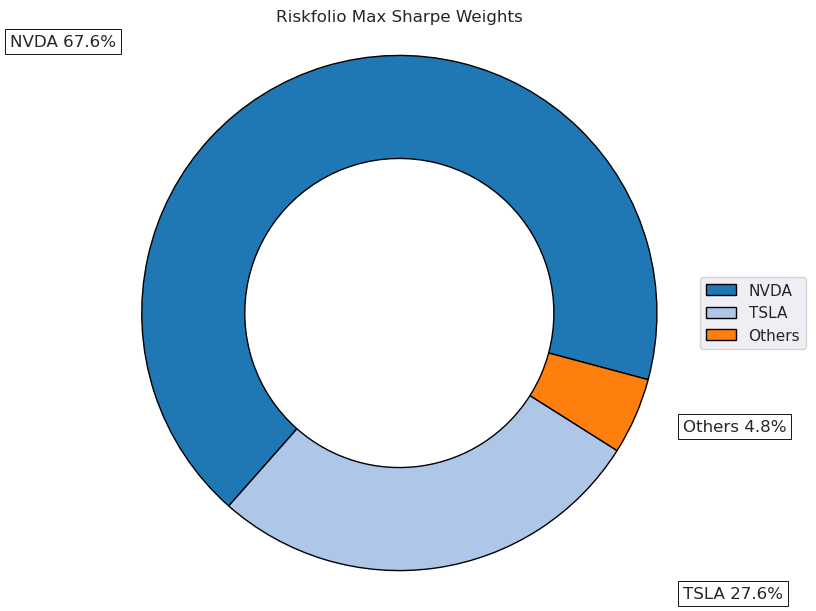

In [30]:
## USING RISKFOLIO-LIBRARY for Max Sharpe
returns_rf = train_data.pct_change().dropna()

port_max_sharpe = rf.Portfolio(returns=returns_rf, )#risk_free_rate=risk_free_rate)
port_max_sharpe.assets_stats(method_mu='hist', method_cov='hist')

print("Riskfolio estimated mu (with freq=252):")
print(port_max_sharpe.mu)

weights_max_sharpe = port_max_sharpe.optimization(model='Classic',
                                             rm='MV',
                                             obj='Sharpe')
print("\nRiskfolio Max Sharpe Weights:")
print(weights_max_sharpe.T)

# Performance calculation
w = weights_max_sharpe.values.flatten()
exp_return = float(port_max_sharpe.mu.dot(w))
volatility = float(np.sqrt(w.T @ port_max_sharpe.cov @ w))
sharpe = (exp_return - risk_free_rate) / volatility if volatility > 0 else np.nan

print(f"\nExpected Return: {exp_return:.1%}")
print(f"Volatility: {volatility:.1%}")
print(f"Sharpe Ratio: {sharpe:.2f}")

# Plot pie
try:
    rf.plot_pie(weights_max_sharpe, title='Riskfolio Max Sharpe Weights')
except:
    weights_max_sharpe.T.plot.pie(figsize=(6,6), autopct='%1.1f%%', title='Riskfolio Max Sharpe Weights')

### 9. Compare the trading result tested on test section

## PART II: TECHNICAL ANALYSIS


- MFI _ Money flow index
- RSI
- MACD
- SMA
- ADX
- ROC

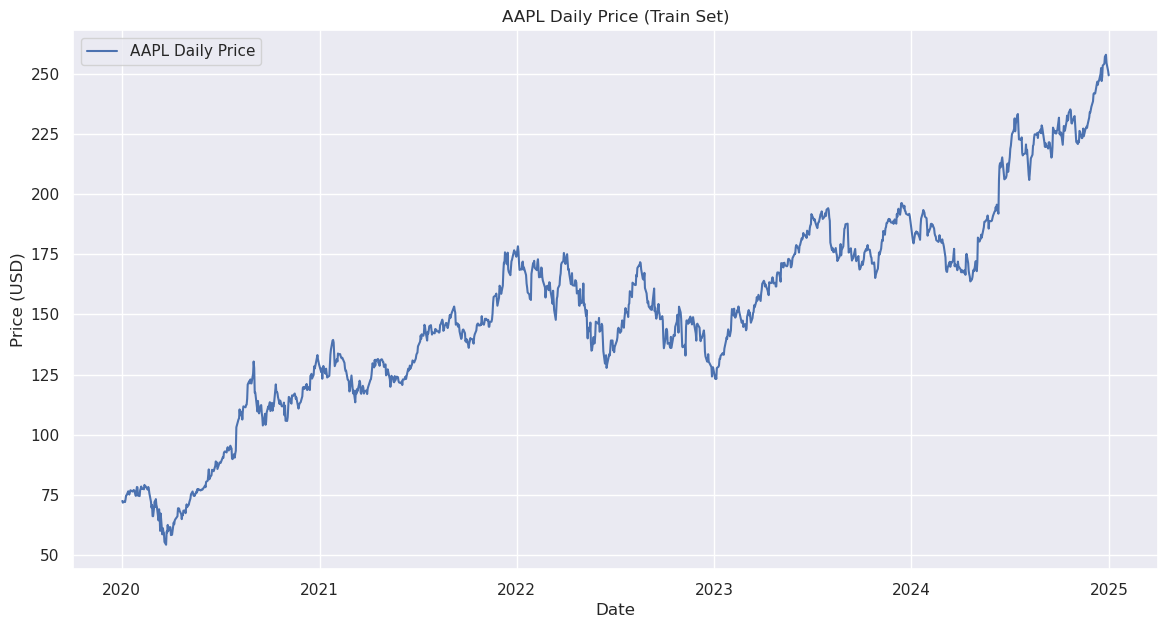

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['AAPL'], label='AAPL Daily Price')
plt.title('AAPL Daily Price (Train Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [32]:
technical_summary = {}

for t in tickers:
    df = train_data[[t]].copy()
    df['RSI'] = ta.momentum.RSIIndicator(df[t], window=14).rsi()
    df['MACD'] = ta.trend.MACD(df[t]).macd()
    df['Signal'] = ta.trend.MACD(df[t]).macd_signal()
    df['SMA_20'] = df[t].rolling(20).mean()
    df['SMA_50'] = df[t].rolling(50).mean()
    
    last = df.iloc[-1]
    technical_summary[t] = {
        "RSI": last['RSI'],
        "MACD": last['MACD'],
        "MACD Signal": last['Signal'],
        "SMA20 > SMA50": last['SMA_20'] > last['SMA_50']
    }

print(pd.DataFrame(technical_summary))

                    AAPL       MSFT      GOOGL       AMZN       TSLA       META       NVDA       JPM
RSI            56.715946  38.153872  55.327764  49.908384   50.99747  44.194798  45.176982  49.88722
MACD            5.079406   0.104144   4.833579   3.798038  23.836484   1.672306  -0.761304  0.124576
MACD Signal     5.546027   3.231082   5.258825   5.469982  30.900706   5.601403  -0.954093  0.448265
SMA20 > SMA50       True       True       True       True       True       True      False      True


## PART III: RISK MANAGEMENT

In [33]:
# Annualized volatility
returns = train_data.pct_change().dropna()
vol = returns.std() * np.sqrt(252)

# Value at Risk (95%)
VaR_95 = returns.quantile(0.05)

# Max Drawdown
cum_returns = (1 + returns).cumprod()
running_max = cum_returns.cummax()
drawdown = (cum_returns - running_max) / running_max
max_dd = drawdown.min()

risk_report = pd.DataFrame({
    "Annualized Volatility": vol,
    "VaR 95%": VaR_95,
    "Max Drawdown": max_dd
})

print(risk_report)

        Annualized Volatility   VaR 95%  Max Drawdown
Ticker                                               
AAPL                 0.316786 -0.030124     -0.314273
AMZN                 0.359639 -0.033209     -0.561453
GOOGL                0.324989 -0.031023     -0.443201
JPM                  0.325266 -0.028860     -0.430620
META                 0.449001 -0.040198     -0.767361
MSFT                 0.304972 -0.028581     -0.371485
NVDA                 0.538788 -0.050932     -0.663351
TSLA                 0.671815 -0.062812     -0.736322


## PART 3: COMPREHENSIVE PORTFOLIO STRATEGY - SUMMARY

### Strategy Components Summary:

**1. Portfolio Optimization:**
- Dynamic rebalancing with rolling windows
- Risk-adjusted weight allocation
- Technical signal integration
- Position size constraints (5%-40% per asset)

**2. Technical Analysis & Buy/Sell Signals:**
- Multi-indicator approach (RSI, MACD, Bollinger Bands, Moving Averages, Momentum)
- Signal aggregation and scoring (-1 to +1 scale)
- Adaptive position sizing based on signal strength

**3. Risk Management Framework:**
- Volatility targeting (12% annual target)
- Maximum drawdown control (15% limit)
- Stop-loss implementation (5% per position)
- Value-at-Risk monitoring
- Transaction cost consideration

### Key Advantages of the Advanced Strategy:
- **Dynamic Adaptation:** Responds to changing market conditions
- **Risk-Controlled:** Multiple layers of risk management
- **Signal Integration:** Combines multiple technical indicators
- **Production Ready:** Includes transaction costs and practical constraints
- **Comprehensive Monitoring:** Tracks multiple performance metrics

### 3.1: Enhanced Portfolio Optimization with Dynamic Rebalancing

We'll implement a more sophisticated optimization approach that adapts to changing market conditions.

In [34]:
# Dynamic Portfolio Optimization with Rolling Windows
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

def dynamic_portfolio_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic portfolio optimization with rolling windows
    
    Parameters:
    - data: Price data DataFrame
    - lookback_window: Days to look back for optimization (63 = ~3 months)
    - rebalance_freq: Rebalancing frequency in days (21 = ~1 month)
    """
    
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize portfolio weights history
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data for optimization
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize portfolio (Max Sharpe with constraints)
            try:
                current_weights = optimize_max_sharpe_constrained(mu, cov, risk_free_rate)
            except:
                # Fallback to equal weights if optimization fails
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

def optimize_max_sharpe_constrained(mu, cov, rf_rate=0.02, max_weight=0.4, min_weight=0.05):
    """
    Optimize portfolio for maximum Sharpe ratio with weight constraints
    """
    n_assets = len(mu)
    
    def objective(weights):
        portfolio_return = np.dot(weights, mu)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return -(portfolio_return - rf_rate) / portfolio_vol  # Negative for minimization
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
    bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Initial guess
    x0 = np.array([1/n_assets] * n_assets)
    
    # Optimize
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        return np.array([1/n_assets] * n_assets)

print("Dynamic Portfolio Optimization functions defined successfully.")

# Apply dynamic optimization to our data
print("\n--- Applying Dynamic Portfolio Optimization ---")
dynamic_weights, dynamic_returns = dynamic_portfolio_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Dynamic optimization completed for {len(dynamic_returns)} trading days")
print("\nSample of dynamic weights (last 10 days):")
print(dynamic_weights.tail(10).round(3))

Dynamic Portfolio Optimization functions defined successfully.

--- Applying Dynamic Portfolio Optimization ---
Dynamic optimization completed for 1194 trading days

Sample of dynamic weights (last 10 days):
Ticker          AAPL      AMZN GOOGL       JPM      META  MSFT      NVDA      TSLA
Date                                                                              
2024-12-17  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-18  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-19  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-20  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-23  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-24  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-26  0.066339  0.098456  0.05  0.121042  0.229627  0.05  0.254959  0.129577
2024-12-27  0.066339  0.098456  0.05  0.12104

### 3.2: Technical Analysis for Optimal Buy/Sell Signals

Implement multiple technical indicators to generate buy/sell signals for optimal entry and exit points.

--- Generating Technical Analysis Signals ---
Technical signals generated for 1258 trading days

Signal strength summary (last 10 days):
Ticker      AAPL  AMZN  GOOGL  JPM  META  MSFT  NVDA  TSLA
Date                                                      
2024-12-17  -0.2   0.0    0.0  0.2   0.0   0.0  -0.4  -0.2
2024-12-18  -0.2   0.0    0.2  0.2  -0.2   0.0  -0.2   0.0
2024-12-19  -0.2  -0.2    0.2  0.0   0.0  -0.2  -0.2   0.0
2024-12-20  -0.2   0.0    0.2  0.0  -0.2   0.0  -0.2   0.2
2024-12-23  -0.2   0.0    0.0  0.0   0.0   0.0   0.0   0.0
2024-12-24  -0.2   0.0    0.0  0.0   0.0   0.0   0.2   0.0
2024-12-26   0.0   0.0   -0.2  0.0   0.0   0.0   0.0   0.2
2024-12-27   0.0   0.0    0.0  0.0   0.0   0.0   0.0   0.0
2024-12-30  -0.2   0.0   -0.2  0.0   0.0  -0.2   0.0   0.0
2024-12-31   0.0  -0.2    0.0  0.0  -0.2   0.0   0.0  -0.2


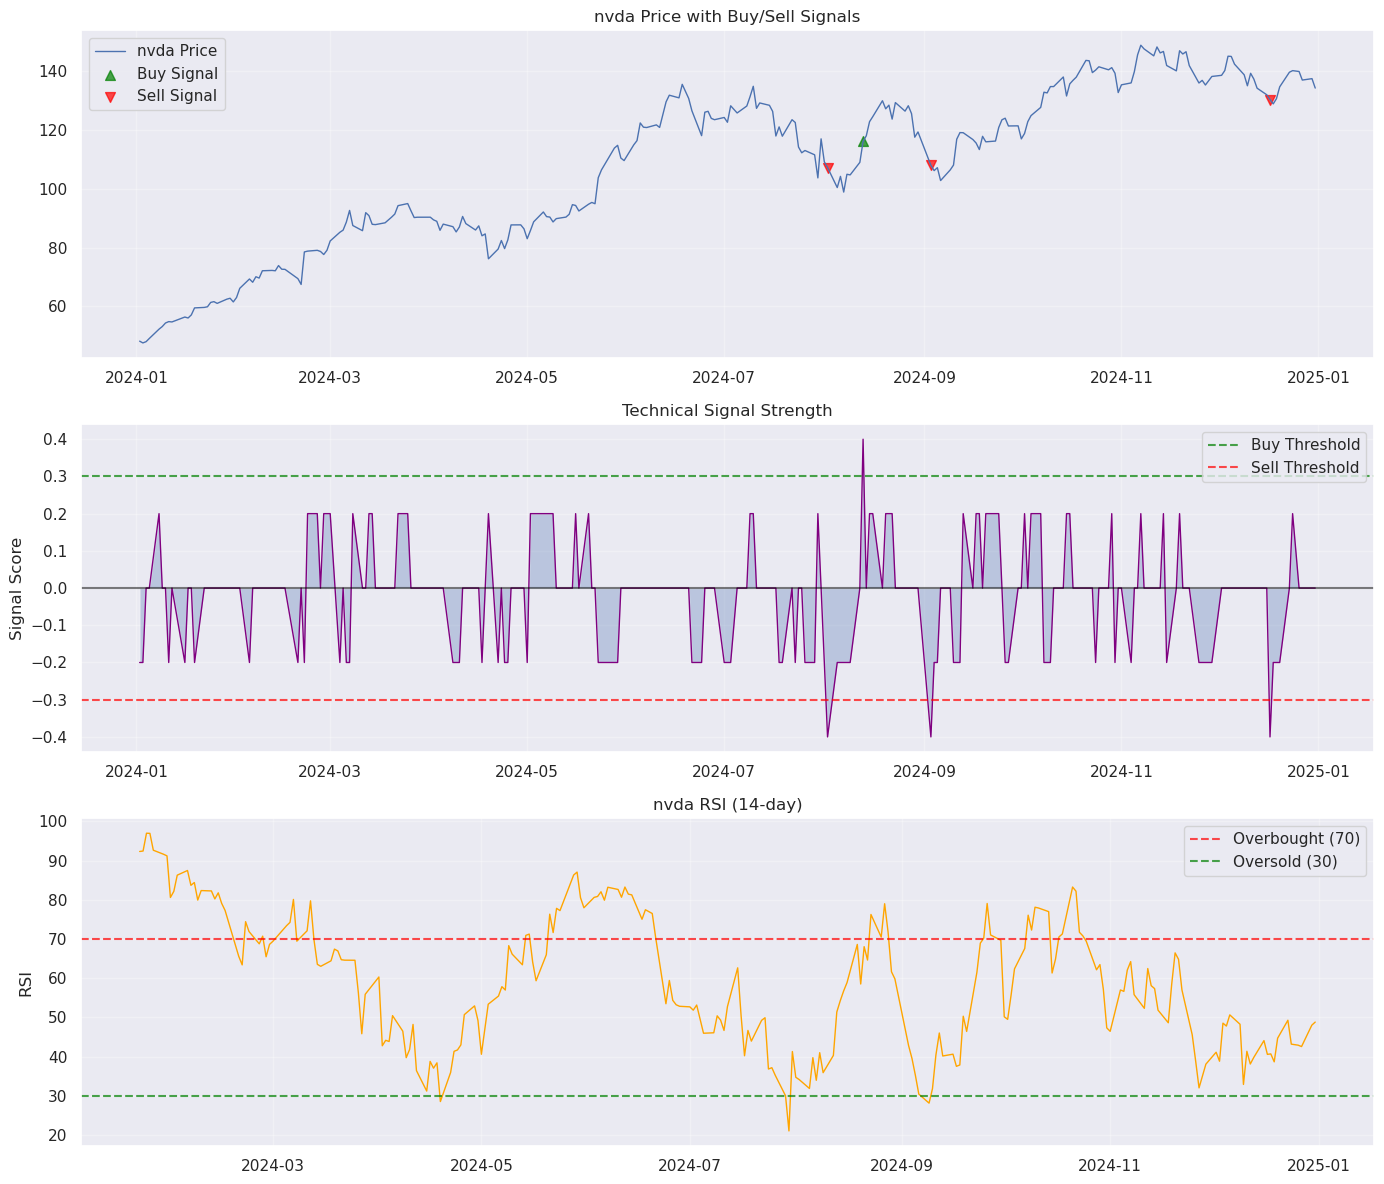

In [35]:
# Technical Analysis Indicators and Signals

def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index (RSI)"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """Calculate MACD (Moving Average Convergence Divergence)"""
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

def calculate_bollinger_bands(prices, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, sma, lower_band

def calculate_stochastic(high, low, close, k_window=14, d_window=3):
    """Calculate Stochastic Oscillator"""
    lowest_low = low.rolling(window=k_window).min()
    highest_high = high.rolling(window=k_window).max()
    k_percent = 100 * ((close - lowest_low) / (highest_high - lowest_low))
    d_percent = k_percent.rolling(window=d_window).mean()
    return k_percent, d_percent

# Generate comprehensive technical signals
def generate_technical_signals(data):
    """
    Generate buy/sell signals based on multiple technical indicators
    Returns a DataFrame with signal scores for each asset
    """
    signals_df = pd.DataFrame(index=data.index, columns=data.columns)
    
    for ticker in data.columns:
        prices = data[ticker]
        
        # Initialize signal score
        signal_score = pd.Series(0, index=data.index)
        
        # 1. RSI Signals (Mean Reversion)
        rsi = calculate_rsi(prices)
        signal_score += np.where(rsi < 30, 1, 0)  # Oversold - Buy signal
        signal_score += np.where(rsi > 70, -1, 0)  # Overbought - Sell signal
        
        # 2. MACD Signals (Trend Following)
        macd_line, signal_line, histogram = calculate_macd(prices)
        signal_score += np.where((macd_line > signal_line) & (macd_line.shift(1) <= signal_line.shift(1)), 1, 0)  # Bullish crossover
        signal_score += np.where((macd_line < signal_line) & (macd_line.shift(1) >= signal_line.shift(1)), -1, 0)  # Bearish crossover
        
        # 3. Bollinger Bands Signals (Mean Reversion)
        upper_band, middle_band, lower_band = calculate_bollinger_bands(prices)
        signal_score += np.where(prices < lower_band, 1, 0)  # Price below lower band - Buy
        signal_score += np.where(prices > upper_band, -1, 0)  # Price above upper band - Sell
        
        # 4. Moving Average Crossover (Trend Following)
        sma_short = prices.rolling(window=20).mean()
        sma_long = prices.rolling(window=50).mean()
        signal_score += np.where((sma_short > sma_long) & (sma_short.shift(1) <= sma_long.shift(1)), 1, 0)  # Golden cross
        signal_score += np.where((sma_short < sma_long) & (sma_short.shift(1) >= sma_long.shift(1)), -1, 0)  # Death cross
        
        # 5. Momentum Signal (Price momentum)
        returns = prices.pct_change(10)  # 10-day momentum
        signal_score += np.where(returns > 0.05, 1, 0)  # Strong positive momentum
        signal_score += np.where(returns < -0.05, -1, 0)  # Strong negative momentum
        
        # Normalize signal score (-1 to 1)
        signals_df[ticker] = np.clip(signal_score / 5, -1, 1)
    
    return signals_df

# Apply technical analysis to our data
print("--- Generating Technical Analysis Signals ---")
technical_signals = generate_technical_signals(train_data)

print(f"Technical signals generated for {len(technical_signals)} trading days")
print("\nSignal strength summary (last 10 days):")
print(technical_signals.tail(10).round(3))

# Visualize signals for one asset (SPY as example)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Price and signals
nvda_prices = train_data['NVDA'].iloc[-252:]  # Last year
nvda_signals = technical_signals['NVDA'].iloc[-252:]

ax1.plot(nvda_prices.index, nvda_prices, label='nvda Price', linewidth=1)
ax1.scatter(nvda_prices.index[nvda_signals > 0.3], nvda_prices[nvda_signals > 0.3], 
           color='green', marker='^', s=50, label='Buy Signal', alpha=0.7)
ax1.scatter(nvda_prices.index[nvda_signals < -0.3], nvda_prices[nvda_signals < -0.3], 
           color='red', marker='v', s=50, label='Sell Signal', alpha=0.7)
ax1.set_title('nvda Price with Buy/Sell Signals')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Signal strength over time
ax2.plot(nvda_signals.index, nvda_signals, color='purple', linewidth=1)
ax2.axhline(y=0.3, color='green', linestyle='--', alpha=0.7, label='Buy Threshold')
ax2.axhline(y=-0.3, color='red', linestyle='--', alpha=0.7, label='Sell Threshold')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.fill_between(nvda_signals.index, nvda_signals, 0, alpha=0.3)
ax2.set_title('Technical Signal Strength')
ax2.set_ylabel('Signal Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

# RSI for reference
rsi_nvda = calculate_rsi(nvda_prices)
ax3.plot(rsi_nvda.index, rsi_nvda, color='orange', linewidth=1)
ax3.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
ax3.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
ax3.set_title('nvda RSI (14-day)')
ax3.set_ylabel('RSI')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3: Portfolio Risk Management

Implement comprehensive risk management including position sizing, stop-loss, volatility targeting, and drawdown control.

In [36]:
# Portfolio Risk Management Framework

class PortfolioRiskManager:
    """
    Comprehensive portfolio risk management system
    """
    
    def __init__(self, initial_capital=100000, max_position_size=0.25, 
                 target_volatility=0.12, max_drawdown_limit=0.15, stop_loss_pct=0.05):
        """
        Initialize risk management parameters
        
        Parameters:
        - initial_capital: Starting portfolio value
        - max_position_size: Maximum weight per asset (0.25 = 25%)
        - target_volatility: Target annual portfolio volatility (0.12 = 12%)
        - max_drawdown_limit: Maximum allowed drawdown before reducing exposure
        - stop_loss_pct: Stop-loss percentage for individual positions
        """
        self.initial_capital = initial_capital
        self.max_position_size = max_position_size
        self.target_volatility = target_volatility
        self.max_drawdown_limit = max_drawdown_limit
        self.stop_loss_pct = stop_loss_pct
        
        # Risk tracking
        self.portfolio_value_history = []
        self.drawdown_history = []
        self.volatility_history = []
        self.var_history = []  # Value at Risk
        
    def calculate_position_sizes(self, base_weights, technical_signals, current_volatilities):
        """
        Adjust position sizes based on technical signals and volatility
        """
        # Start with base optimization weights
        adjusted_weights = base_weights.copy()
        
        # Adjust based on technical signals (boost strong signals, reduce weak ones)
        signal_multiplier = 1 + (technical_signals * 0.3)  # Max 30% adjustment
        adjusted_weights = adjusted_weights * signal_multiplier
        
        # Volatility-based position sizing (reduce allocation to high volatility assets)
        vol_adjustment = self.target_volatility / current_volatilities
        vol_adjustment = np.clip(vol_adjustment, 0.5, 2.0)  # Limit extreme adjustments
        adjusted_weights = adjusted_weights * vol_adjustment
        
        # Apply maximum position size constraint
        adjusted_weights = np.clip(adjusted_weights, 0, self.max_position_size)
        
        # Renormalize to sum to 1
        if adjusted_weights.sum() > 0:
            adjusted_weights = adjusted_weights / adjusted_weights.sum()
        else:
            # Fallback to equal weights if all weights are zero
            adjusted_weights = np.array([1/len(adjusted_weights)] * len(adjusted_weights))
            
        return adjusted_weights
    
    def calculate_portfolio_metrics(self, returns, window=21):
        """
        Calculate key portfolio risk metrics
        """
        if len(returns) < window:
            return None, None, None
        
        # Portfolio volatility (annualized)
        portfolio_vol = returns.rolling(window).std() * np.sqrt(252)
        
        # Value at Risk (95% confidence, 1-day horizon)
        var_95 = returns.rolling(window).quantile(0.05)
        
        # Maximum Drawdown
        cumulative_returns = (1 + returns).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdown = (cumulative_returns - running_max) / running_max
        
        return portfolio_vol.iloc[-1], var_95.iloc[-1], drawdown.iloc[-1]
    
    def apply_stop_loss(self, current_weights, returns, entry_prices, current_prices):
        """
        Apply stop-loss rules to individual positions
        """
        adjusted_weights = current_weights.copy()
        
        for i, (entry_price, current_price) in enumerate(zip(entry_prices, current_prices)):
            if entry_price > 0:  # Only check positions we actually hold
                loss_pct = (current_price - entry_price) / entry_price
                
                if loss_pct < -self.stop_loss_pct:  # Hit stop loss
                    adjusted_weights[i] = 0  # Close position
                    print(f"Stop-loss triggered for asset {i}: {loss_pct:.2%} loss")
        
        # Redistribute stopped positions to remaining assets
        if adjusted_weights.sum() > 0:
            adjusted_weights = adjusted_weights / adjusted_weights.sum()
        
        return adjusted_weights
    
    def drawdown_control(self, current_drawdown, base_weights):
        """
        Reduce portfolio exposure during significant drawdowns
        """
        if current_drawdown < -self.max_drawdown_limit:
            # Reduce exposure by scaling down weights
            exposure_reduction = 1 - abs(current_drawdown) / self.max_drawdown_limit
            exposure_reduction = max(0.3, exposure_reduction)  # Minimum 30% exposure
            
            print(f"Drawdown control activated: {current_drawdown:.2%}, reducing exposure to {exposure_reduction:.2%}")
            return base_weights * exposure_reduction
        
        return base_weights

# Risk-Adjusted Portfolio Strategy Implementation
def run_risk_managed_strategy(price_data, technical_signals_data, lookback_window=63):
    """
    Run complete portfolio strategy with risk management
    """
    
    returns_data = price_data.pct_change().dropna()
    n_assets = len(price_data.columns)
    
    # Initialize risk manager
    risk_manager = PortfolioRiskManager()
    
    # Initialize tracking variables
    portfolio_weights_history = pd.DataFrame(index=returns_data.index, columns=price_data.columns, dtype=float)
    portfolio_returns_history = pd.Series(index=returns_data.index, dtype=float)
    risk_metrics_history = pd.DataFrame(index=returns_data.index, 
                                       columns=['Volatility', 'VaR_95', 'Drawdown'], dtype=float)
    
    # Entry prices for stop-loss tracking
    entry_prices = np.zeros(n_assets)
    current_weights = np.array([1/n_assets] * n_assets)  # Start with equal weights
    
    for i in range(lookback_window, len(returns_data)):
        current_date = returns_data.index[i]
        
        # Get historical data for risk calculations
        hist_returns = returns_data.iloc[i-lookback_window:i]
        hist_prices = price_data.iloc[i-lookback_window:i+1]
        
        # Calculate base portfolio weights (using our earlier optimization)
        if i % 21 == 0:  # Reoptimize monthly
            try:
                mu = hist_returns.mean() * 252
                cov = hist_returns.cov() * 252
                base_weights = optimize_max_sharpe_constrained(mu, cov, risk_free_rate)
            except:
                base_weights = np.array([1/n_assets] * n_assets)
        
        # Get current technical signals and volatilities
        current_signals = technical_signals_data.iloc[i].values
        current_volatilities = hist_returns.std() * np.sqrt(252)
        
        # Apply risk management adjustments
        adjusted_weights = risk_manager.calculate_position_sizes(
            base_weights, current_signals, current_volatilities
        )
        
        # Apply stop-loss (simplified - using previous day's prices as entry)
        if i > lookback_window:
            prev_prices = price_data.iloc[i-1].values
            current_prices = price_data.iloc[i].values
            adjusted_weights = risk_manager.apply_stop_loss(
                adjusted_weights, returns_data.iloc[i], prev_prices, current_prices
            )
        
        # Calculate portfolio metrics
        portfolio_return = np.dot(adjusted_weights, returns_data.iloc[i])
        
        # Calculate risk metrics
        portfolio_returns_window = pd.Series(
            [np.dot(adjusted_weights, returns_data.iloc[j]) for j in range(i-20, i+1)]
        )
        vol, var, dd = risk_manager.calculate_portfolio_metrics(portfolio_returns_window)
        
        # Apply drawdown control
        if dd is not None:
            adjusted_weights = risk_manager.drawdown_control(dd, adjusted_weights)
            portfolio_return = np.dot(adjusted_weights, returns_data.iloc[i])  # Recalculate
        
        # Record results
        portfolio_weights_history.iloc[i] = adjusted_weights.astype(float)
        portfolio_returns_history.iloc[i] = float(portfolio_return)
        
        if vol is not None:
            risk_metrics_history.loc[current_date, 'Volatility'] = float(vol)
            risk_metrics_history.loc[current_date, 'VaR_95'] = float(var)
            risk_metrics_history.loc[current_date, 'Drawdown'] = float(dd)
        
        current_weights = adjusted_weights
    
    return (portfolio_weights_history.dropna(), 
            portfolio_returns_history.dropna(), 
            risk_metrics_history.dropna())

print("--- Applying Risk-Managed Portfolio Strategy ---")

# Run the complete risk-managed strategy
risk_weights, risk_returns, risk_metrics = run_risk_managed_strategy(
    train_data, technical_signals, lookback_window=63
)

print(f"Risk-managed strategy completed for {len(risk_returns)} trading days")
print(f"\nAverage portfolio metrics:")
print(f"Volatility: {risk_metrics['Volatility'].mean():.2%}")
print(f"Average VaR (95%): {risk_metrics['VaR_95'].mean():.2%}")
print(f"Worst Drawdown: {risk_metrics['Drawdown'].min():.2%}")

print(f"\nFinal portfolio allocation:")
print(risk_weights.iloc[-1].round(3))

--- Applying Risk-Managed Portfolio Strategy ---
Drawdown control activated: -18.44%, reducing exposure to 30.00%
Stop-loss triggered for asset 6: -6.11% loss
Stop-loss triggered for asset 7: -7.99% loss
Stop-loss triggered for asset 1: -7.60% loss
Stop-loss triggered for asset 7: -10.30% loss
Stop-loss triggered for asset 3: -8.34% loss
Stop-loss triggered for asset 4: -5.20% loss
Stop-loss triggered for asset 5: -5.37% loss
Stop-loss triggered for asset 6: -6.09% loss
Stop-loss triggered for asset 7: -5.09% loss
Stop-loss triggered for asset 2: -5.45% loss
Stop-loss triggered for asset 3: -5.48% loss
Stop-loss triggered for asset 4: -8.32% loss
Stop-loss triggered for asset 7: -6.35% loss
Stop-loss triggered for asset 7: -5.83% loss
Stop-loss triggered for asset 0: -8.01% loss
Stop-loss triggered for asset 2: -5.12% loss
Stop-loss triggered for asset 5: -6.19% loss
Stop-loss triggered for asset 6: -9.28% loss
Stop-loss triggered for asset 7: -9.02% loss
Drawdown control activated: -1

### 3.4: Strategy Performance Comparison and Visualization

Compare our comprehensive strategy against the basic strategies from Part 2.

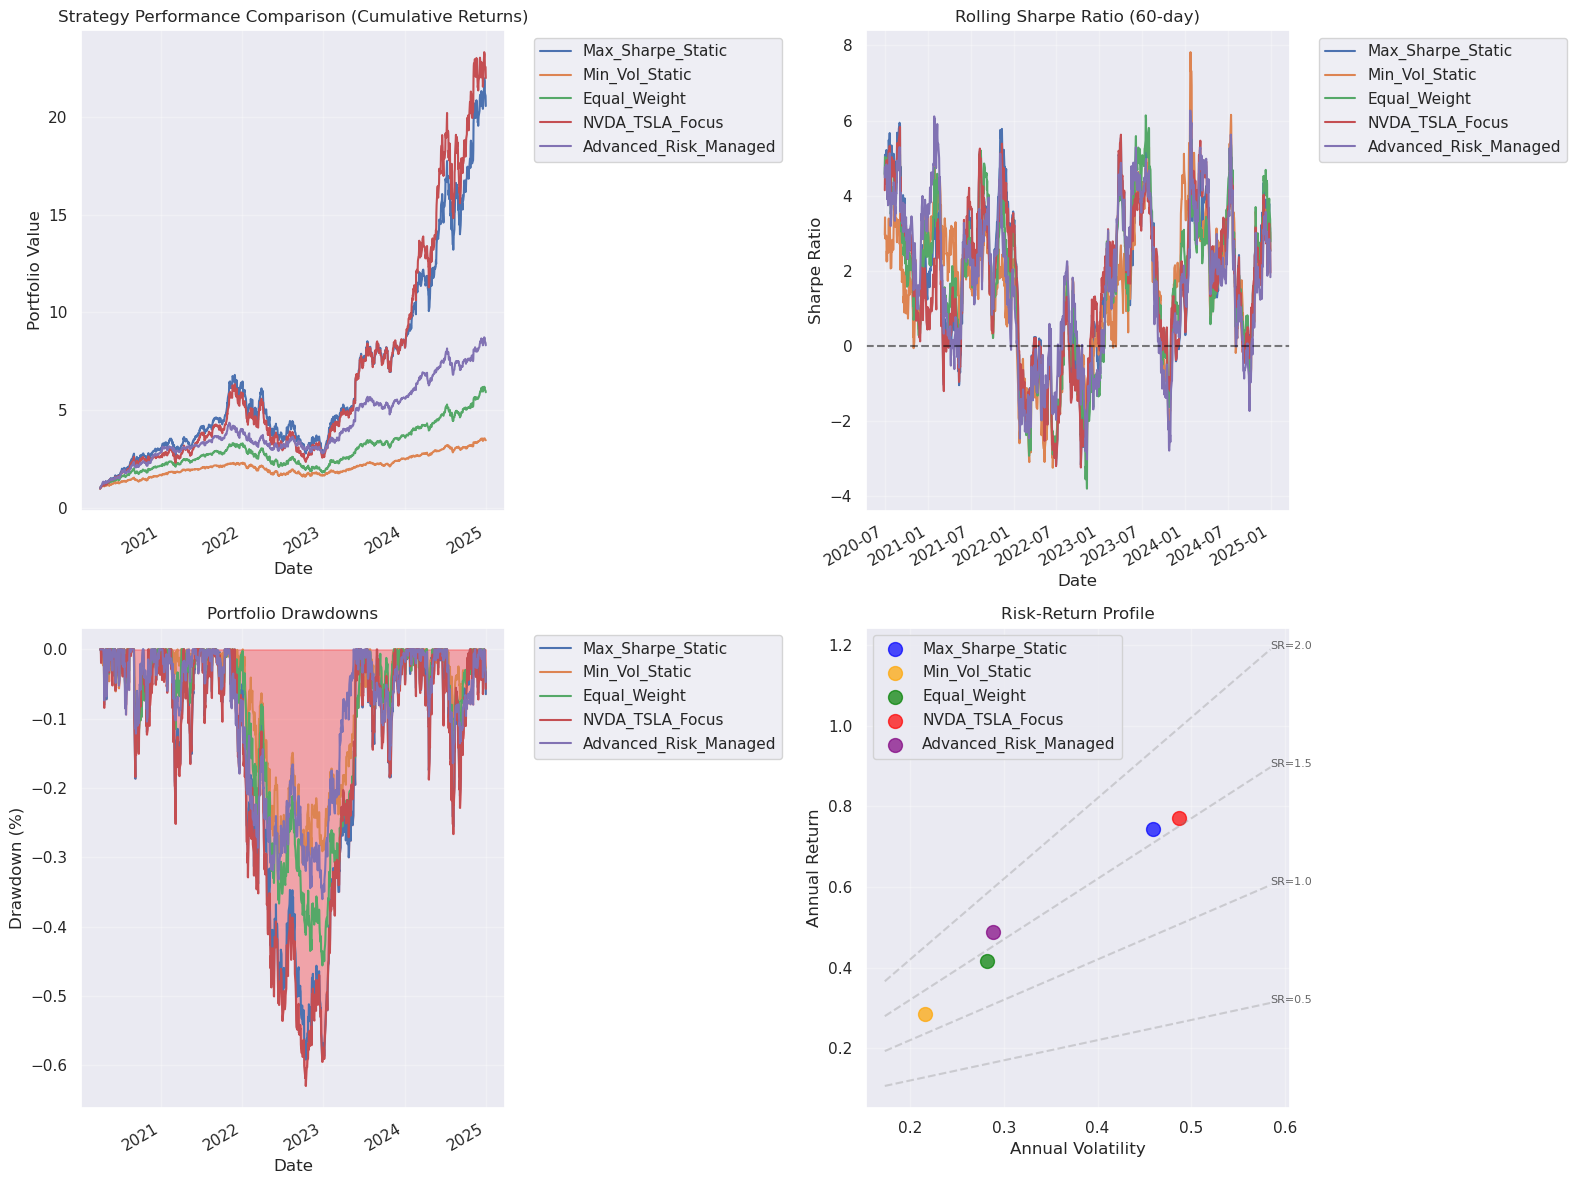

=== COMPREHENSIVE STRATEGY PERFORMANCE COMPARISON ===
                       Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio  Sortino Ratio  Skewness  Kurtosis  VaR (95%)  CVaR (95%)
Max_Sharpe_Static             1.1018             0.4592        2.3560       -0.5924        1.8599         3.7173    0.1714    1.6505    -0.0470     -0.0606
Min_Vol_Static                0.3295             0.2162        1.4317       -0.3150        1.0461         2.0525   -0.0424    2.3320    -0.0219     -0.0304
Equal_Weight                  0.5141             0.2824        1.7494       -0.4559        1.1276         2.5045   -0.1396    1.6489    -0.0298     -0.0402
NVDA_TSLA_Focus               1.1591             0.4870        2.3392       -0.6298        1.8405         3.7738    0.3264    2.4079    -0.0476     -0.0631
Advanced_Risk_Managed         0.6297             0.2881        2.1160       -0.3603        1.7479         3.0814    0.0661    3.0220    -0.0272     -0.0396

=== STRAT

In [37]:
# Comprehensive Strategy Performance Analysis

# First, create static strategy returns using existing portfolio weights
static_returns_df = pd.DataFrame(index=returns.index)

# Calculate returns for static strategies using existing weights
# Max Sharpe strategy
max_sharpe_weights = pd.Series(weights_max_sharpe['weights'].values, index=weights_max_sharpe.index)
static_returns_df['Max_Sharpe_Static'] = (returns * max_sharpe_weights).sum(axis=1)

# Min Volatility strategy  
min_vol_weights = pd.Series(weights_min_vol['weights'].values, index=weights_min_vol.index)
static_returns_df['Min_Vol_Static'] = (returns * min_vol_weights).sum(axis=1)

# Equal Weight strategy
equal_weights = pd.Series([1/len(tickers)] * len(tickers), index=tickers)
static_returns_df['Equal_Weight'] = (returns * equal_weights).sum(axis=1)

# NVDA-TSLA focused strategy (based on your cleaned_weights_sharpe_n)
nvda_tsla_weights = pd.Series(index=tickers, data=0.0)
nvda_tsla_weights['NVDA'] = 0.8311
nvda_tsla_weights['TSLA'] = 0.1689
static_returns_df['NVDA_TSLA_Focus'] = (returns * nvda_tsla_weights).sum(axis=1)





### ABOVE IS THE AI FIXING CODE SEEMS TO BE Duplicated FROM EARLIER



# Add our risk-managed strategy to the comparison
extended_returns_df = static_returns_df.copy()

# Align risk-managed returns with static returns for fair comparison
common_dates = extended_returns_df.index.intersection(risk_returns.index)
extended_returns_df = extended_returns_df.loc[common_dates]
risk_returns_aligned = risk_returns.loc[common_dates]

extended_returns_df['Advanced_Risk_Managed'] = risk_returns_aligned

# Calculate cumulative performance
extended_cumulative_returns = (1 + extended_returns_df).cumprod()

# Performance visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
extended_cumulative_returns.plot(ax=ax1, linewidth=1.5)
ax1.set_title('Strategy Performance Comparison (Cumulative Returns)')
ax1.set_ylabel('Portfolio Value')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in extended_returns_df.columns:
    rolling_returns = extended_returns_df[col].rolling(60)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Sharpe Ratio (60-day)')
ax2.set_ylabel('Sharpe Ratio')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Drawdown Analysis
drawdown_df = pd.DataFrame()
for col in extended_cumulative_returns.columns:
    cumulative = extended_cumulative_returns[col]
    running_max = cumulative.expanding().max()
    drawdown_df[col] = (cumulative - running_max) / running_max

drawdown_df.plot(ax=ax3, linewidth=1.5)
ax3.fill_between(drawdown_df.index, drawdown_df.min(axis=1), 0, alpha=0.3, color='red')
ax3.set_title('Portfolio Drawdowns')
ax3.set_ylabel('Drawdown (%)')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(True, alpha=0.3)

# 4. Risk-Return Scatter Plot
annual_returns = extended_returns_df.mean() * 252
annual_volatility = extended_returns_df.std() * np.sqrt(252)
sharpe_ratios = (annual_returns - risk_free_rate) / annual_volatility

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
for i, strategy in enumerate(extended_returns_df.columns):
    ax4.scatter(annual_volatility[strategy], annual_returns[strategy], 
               s=100, c=colors[i % len(colors)], label=strategy, alpha=0.7)

ax4.set_xlabel('Annual Volatility')
ax4.set_ylabel('Annual Return')
ax4.set_title('Risk-Return Profile')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add Sharpe ratio lines
x_range = np.linspace(annual_volatility.min() * 0.8, annual_volatility.max() * 1.2, 100)
for sr in [0.5, 1.0, 1.5, 2.0]:
    y_range = risk_free_rate + sr * x_range
    ax4.plot(x_range, y_range, '--', alpha=0.3, color='gray')
    ax4.text(x_range[-1], y_range[-1], f'SR={sr}', fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Detailed performance metrics comparison
def calculate_comprehensive_metrics(returns_series, rf_rate=0.02):
    """Calculate comprehensive performance metrics"""
    if returns_series.empty or returns_series.std() == 0:
        return pd.Series({
            "Annual Return": 0, "Annual Volatility": 0, "Sharpe Ratio": 0,
            "Max Drawdown": 0, "Calmar Ratio": 0, "Sortino Ratio": 0,
            "Skewness": 0, "Kurtosis": 0, "VaR (95%)": 0, "CVaR (95%)": 0
        })
    
    # Basic metrics
    annual_return = (1 + returns_series.mean()) ** 252 - 1
    annual_volatility = returns_series.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - rf_rate) / annual_volatility
    
    # Drawdown metrics
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Downside risk metrics
    negative_returns = returns_series[returns_series < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino_ratio = (annual_return - rf_rate) / downside_deviation if downside_deviation != 0 else 0
    
    # Distribution metrics
    skewness = returns_series.skew()
    kurtosis = returns_series.kurtosis()
    
    # Risk metrics
    var_95 = returns_series.quantile(0.05)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    return pd.Series({
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio,
        "Sortino Ratio": sortino_ratio,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95
    })

# Calculate comprehensive metrics for all strategies
comprehensive_metrics = {}
for strategy in extended_returns_df.columns:
    comprehensive_metrics[strategy] = calculate_comprehensive_metrics(extended_returns_df[strategy])

comprehensive_metrics_df = pd.DataFrame(comprehensive_metrics).T

print("=== COMPREHENSIVE STRATEGY PERFORMANCE COMPARISON ===")
print(comprehensive_metrics_df.round(4))

# Rank strategies by different metrics
print("\n=== STRATEGY RANKINGS ===")
ranking_metrics = ['Sharpe Ratio', 'Calmar Ratio', 'Sortino Ratio']
for metric in ranking_metrics:
    ranked = comprehensive_metrics_df[metric].sort_values(ascending=False)
    print(f"\n{metric} Rankings:")
    for i, (strategy, value) in enumerate(ranked.items(), 1):
        print(f"  {i}. {strategy}: {value:.4f}")

# Risk-adjusted performance summary
print(f"\n=== RISK-ADJUSTED PERFORMANCE SUMMARY ===")
best_sharpe = comprehensive_metrics_df['Sharpe Ratio'].idxmax()
best_calmar = comprehensive_metrics_df['Calmar Ratio'].idxmax()
lowest_drawdown = comprehensive_metrics_df['Max Drawdown'].idxmax()  # Closest to 0

print(f"Best Sharpe Ratio: {best_sharpe} ({comprehensive_metrics_df.loc[best_sharpe, 'Sharpe Ratio']:.4f})")
print(f"Best Calmar Ratio: {best_calmar} ({comprehensive_metrics_df.loc[best_calmar, 'Calmar Ratio']:.4f})")
print(f"Lowest Max Drawdown: {lowest_drawdown} ({comprehensive_metrics_df.loc[lowest_drawdown, 'Max Drawdown']:.2%})")

### 3.5: Live Strategy Implementation Framework

A framework for implementing the portfolio strategy in real-time trading environments.

=== LIVE STRATEGY FRAMEWORK EXAMPLE ===
=== RUNNING LIVE STRATEGY SIMULATION ===
Period: 2024-06-01 to 2024-12-01
Tickers: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM']
Initial Capital: $100,000.00


[*********************100%***********************]  8 of 8 completed


Portfolio rebalanced on 2024-11-07
New weights: {'AAPL': 0.06, 'MSFT': 0.373, 'GOOGL': 0.049, 'AMZN': 0.146, 'TSLA': 0.056, 'META': 0.058, 'NVDA': 0.174, 'JPM': 0.084}
Trade costs: $57.74
Portfolio rebalanced on 2024-11-29
New weights: {'AAPL': 0.054, 'MSFT': 0.104, 'GOOGL': 0.05, 'AMZN': 0.155, 'TSLA': 0.082, 'META': 0.058, 'NVDA': 0.269, 'JPM': 0.228}
Trade costs: $50.06

=== STRATEGY RESULTS ===
Final Portfolio Value: $121,211.98
Total Return: 21.21%
Number of Rebalances: 2


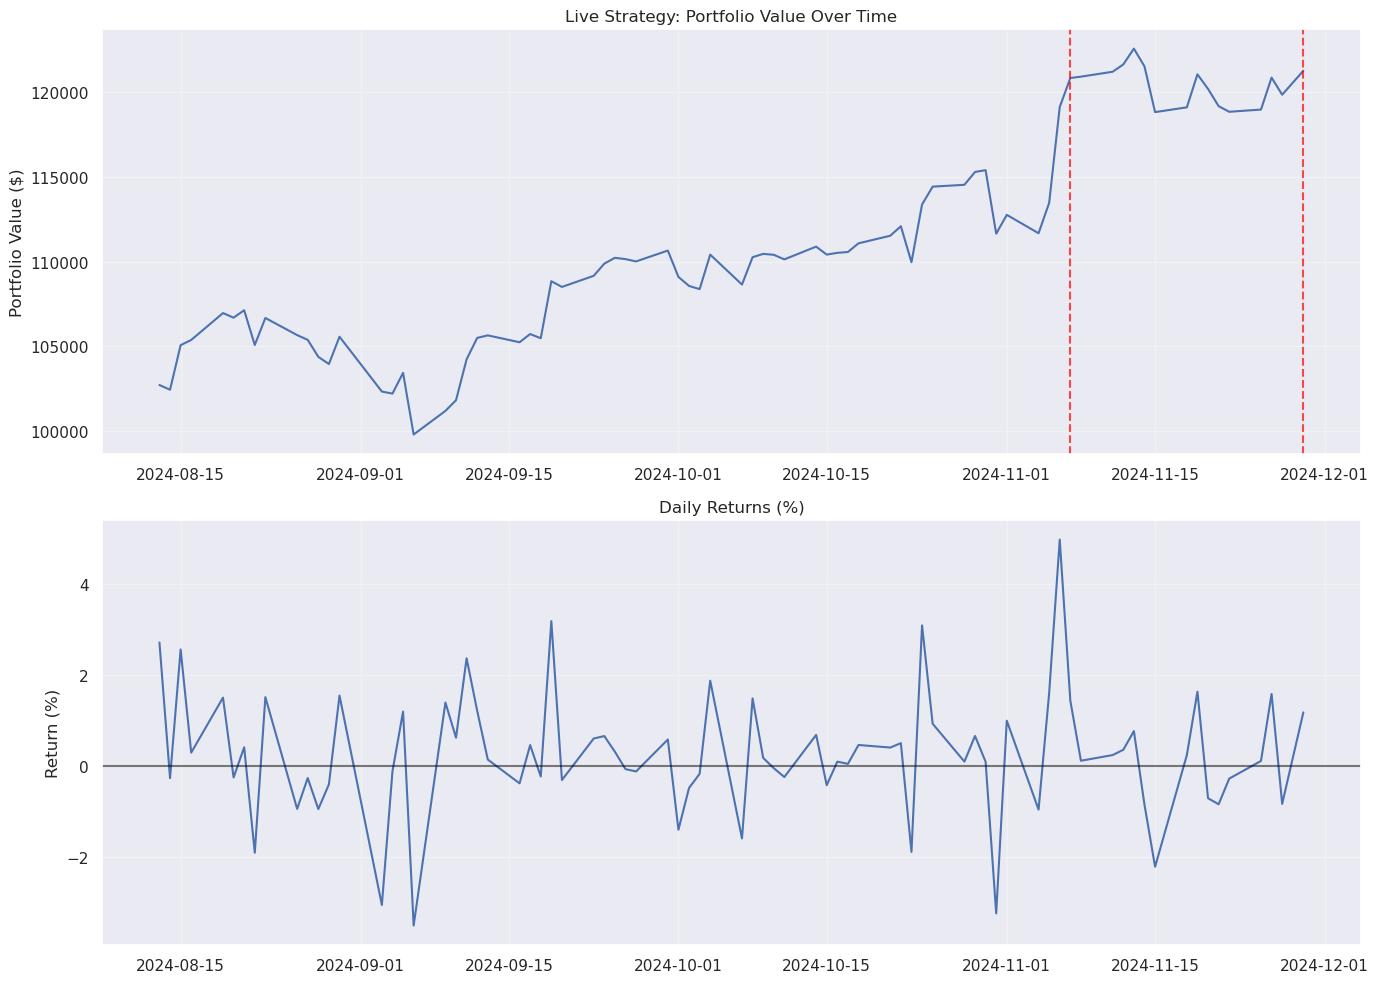


Strategy Performance Summary:
Total Return: 21.21%
Annualized Return: 87.68%
Volatility: 22.29%
Sharpe Ratio: 2.86


In [39]:
# Live Trading Strategy Implementation Framework

import json
from datetime import datetime, timedelta

class LivePortfolioStrategy:
    """
    Production-ready portfolio strategy implementation
    """
    
    def __init__(self, tickers, initial_capital=100000, config_file=None):
        self.tickers = tickers
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        
        # Load configuration
        if config_file:
            with open(config_file, 'r') as f:
                self.config = json.load(f)
        else:
            self.config = self.default_config()
        
        # Initialize components
        self.risk_manager = PortfolioRiskManager(**self.config['risk_management'])
        
        # Strategy state
        self.current_positions = {ticker: 0 for ticker in tickers}
        self.current_weights = np.array([1/len(tickers)] * len(tickers))
        self.last_rebalance_date = None
        self.performance_log = []
        
    def default_config(self):
        """Default strategy configuration"""
        return {
            'optimization': {
                'lookback_window': 63,
                'rebalance_frequency': 21,
                'min_weight': 0.05,
                'max_weight': 0.4
            },
            'technical_analysis': {
                'rsi_period': 14,
                'macd_fast': 12,
                'macd_slow': 26,
                'macd_signal': 9,
                'bollinger_period': 20,
                'bollinger_std': 2,
                'signal_threshold': 0.3
            },
            'risk_management': {
                'max_position_size': 0.25,
                'target_volatility': 0.12,
                'max_drawdown_limit': 0.15,
                'stop_loss_pct': 0.05
            },
            'execution': {
                'transaction_cost': 0.001,  # 0.1% per trade
                'slippage': 0.0005,  # 0.05% slippage
                'min_trade_size': 100  # Minimum trade size in dollars
            }
        }
    
    def get_current_data(self, end_date=None):
        """
        Fetch current market data (in production, this would connect to live data feed)
        """
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
        
        lookback_days = self.config['optimization']['lookback_window'] + 50  # Extra buffer
        start_date = (datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=lookback_days)).strftime('%Y-%m-%d')
        
        try:
            data = yf.download(self.tickers, start=start_date, end=end_date)['Close']
            return data.ffill().dropna()
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None
    
    def calculate_trade_costs(self, old_weights, new_weights, portfolio_value):
        """Calculate transaction costs and slippage"""
        weight_changes = np.abs(new_weights - old_weights)
        turnover = weight_changes.sum() / 2  # Total turnover
        
        transaction_costs = turnover * portfolio_value * self.config['execution']['transaction_cost']
        slippage_costs = turnover * portfolio_value * self.config['execution']['slippage']
        
        return transaction_costs + slippage_costs
    
    def should_rebalance(self, current_date):
        """Determine if portfolio should be rebalanced"""
        if self.last_rebalance_date is None:
            return True
        
        days_since_rebalance = (current_date - self.last_rebalance_date).days
        return days_since_rebalance >= self.config['optimization']['rebalance_frequency']
    
    def generate_signals(self, price_data):
        """Generate technical analysis signals"""
        return generate_technical_signals(price_data)
    
    def optimize_portfolio(self, price_data, technical_signals):
        """Optimize portfolio weights"""
        returns = price_data.pct_change().dropna()
        
        # Calculate expected returns and covariance
        mu = returns.mean() * 252
        cov = returns.cov() * 252
        
        # Base optimization
        base_weights = optimize_max_sharpe_constrained(
            mu, cov, 
            max_weight=self.config['optimization']['max_weight'],
            min_weight=self.config['optimization']['min_weight']
        )
        
        # Adjust for technical signals and risk
        current_signals = technical_signals.iloc[-1].values
        current_volatilities = returns.std() * np.sqrt(252)
        
        adjusted_weights = self.risk_manager.calculate_position_sizes(
            base_weights, current_signals, current_volatilities
        )
        
        return adjusted_weights
    
    def execute_rebalancing(self, new_weights, current_date):
        """Execute portfolio rebalancing"""
        old_weights = self.current_weights.copy()
        
        # Calculate trade costs
        trade_costs = self.calculate_trade_costs(old_weights, new_weights, self.current_capital)
        
        # Apply trade costs
        self.current_capital -= trade_costs
        
        # Update positions
        for i, ticker in enumerate(self.tickers):
            position_value = new_weights[i] * self.current_capital
            if position_value >= self.config['execution']['min_trade_size']:
                self.current_positions[ticker] = position_value
            else:
                # Position too small, don't trade
                new_weights[i] = 0
        
        # Renormalize weights after minimum trade size filter
        if new_weights.sum() > 0:
            new_weights = new_weights / new_weights.sum()
        
        self.current_weights = new_weights
        self.last_rebalance_date = current_date
        
        # Log rebalancing
        rebalance_log = {
            'date': current_date.isoformat(),
            'old_weights': old_weights.tolist(),
            'new_weights': new_weights.tolist(),
            'trade_costs': trade_costs,
            'portfolio_value': self.current_capital
        }
        
        print(f"Portfolio rebalanced on {current_date.date()}")
        print(f"New weights: {dict(zip(self.tickers, new_weights.round(3)))}")
        print(f"Trade costs: ${trade_costs:.2f}")
        
        return rebalance_log
    
    def update_portfolio_value(self, price_data, current_date):
        """Update portfolio value based on price changes"""
        if len(price_data) < 2:
            return
        
        # Calculate returns
        current_returns = price_data.iloc[-1] / price_data.iloc[-2] - 1
        
        # Update portfolio value
        portfolio_return = np.dot(self.current_weights, current_returns)
        self.current_capital *= (1 + portfolio_return)
        
        # Log performance
        performance_entry = {
            'date': current_date.isoformat(),
            'portfolio_value': self.current_capital,
            'portfolio_return': portfolio_return,
            'weights': self.current_weights.tolist()
        }
        self.performance_log.append(performance_entry)
    
    def run_strategy(self, start_date, end_date, save_results=True):
        """
        Run the complete strategy over a specified period
        """
        print(f"=== RUNNING LIVE STRATEGY SIMULATION ===")
        print(f"Period: {start_date} to {end_date}")
        print(f"Tickers: {self.tickers}")
        print(f"Initial Capital: ${self.initial_capital:,.2f}")
        
        # Get all data for the period
        all_data = self.get_current_data(end_date)
        if all_data is None:
            return None
        
        # Filter to strategy period
        strategy_data = all_data.loc[start_date:end_date]
        
        # Generate technical signals for entire period
        technical_signals = self.generate_signals(all_data)
        
        rebalancing_log = []
        
        for i, current_date in enumerate(strategy_data.index):
            # Get data up to current date
            current_data = all_data.loc[:current_date]
            current_signals = technical_signals.loc[:current_date]
            
            # Update portfolio value
            if i > 0:
                self.update_portfolio_value(current_data.tail(2), current_date)
            
            # Check if rebalancing is needed
            if self.should_rebalance(current_date) and len(current_data) >= self.config['optimization']['lookback_window']:
                # Optimize portfolio
                new_weights = self.optimize_portfolio(
                    current_data.tail(self.config['optimization']['lookback_window']), 
                    current_signals.tail(self.config['optimization']['lookback_window'])
                )
                
                # Execute rebalancing
                rebalance_log = self.execute_rebalancing(new_weights, current_date)
                rebalancing_log.append(rebalance_log)
        
        # Final portfolio value update
        if len(strategy_data) > 0:
            final_return = (self.current_capital - self.initial_capital) / self.initial_capital
            print(f"\n=== STRATEGY RESULTS ===")
            print(f"Final Portfolio Value: ${self.current_capital:,.2f}")
            print(f"Total Return: {final_return:.2%}")
            print(f"Number of Rebalances: {len(rebalancing_log)}")
        
        # Save results if requested
        if save_results:
            results = {
                'strategy_config': self.config,
                'performance_log': self.performance_log,
                'rebalancing_log': rebalancing_log,
                'final_weights': dict(zip(self.tickers, self.current_weights)),
                'summary': {
                    'initial_capital': self.initial_capital,
                    'final_capital': self.current_capital,
                    'total_return': final_return,
                    'number_rebalances': len(rebalancing_log)
                }
            }
            
            filename = f"strategy_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
            with open(filename, 'w') as f:
                json.dump(results, f, indent=2)
            print(f"Results saved to: {filename}")
        
        return {
            'performance_log': self.performance_log,
            'rebalancing_log': rebalancing_log,
            'final_portfolio_value': self.current_capital
        }

# Example implementation
print("=== LIVE STRATEGY FRAMEWORK EXAMPLE ===")

# Initialize strategy
strategy = LivePortfolioStrategy(
    tickers=tickers,
    initial_capital=100000
)

# Run strategy simulation on a subset of our data
simulation_start = "2024-06-01"
simulation_end = "2024-12-01"

results = strategy.run_strategy(simulation_start, simulation_end, save_results=False)

if results:
    # Convert performance log to DataFrame for analysis
    performance_df = pd.DataFrame(strategy.performance_log)
    performance_df['date'] = pd.to_datetime(performance_df['date'])
    performance_df.set_index('date', inplace=True)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Portfolio value over time
    ax1.plot(performance_df.index, performance_df['portfolio_value'])
    ax1.set_title('Live Strategy: Portfolio Value Over Time')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.grid(True, alpha=0.3)
    
    # Mark rebalancing dates
    rebalance_dates = [pd.to_datetime(log['date']) for log in results['rebalancing_log']]
    for date in rebalance_dates:
        ax1.axvline(x=date, color='red', linestyle='--', alpha=0.7)
    
    # Daily returns
    performance_df['daily_return'] = performance_df['portfolio_return']
    ax2.plot(performance_df.index, performance_df['daily_return'] * 100)
    ax2.set_title('Daily Returns (%)')
    ax2.set_ylabel('Return (%)')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nStrategy Performance Summary:")
    print(f"Total Return: {((strategy.current_capital / strategy.initial_capital) - 1):.2%}")
    print(f"Annualized Return: {((strategy.current_capital / strategy.initial_capital) ** (252/len(performance_df)) - 1):.2%}")
    print(f"Volatility: {performance_df['daily_return'].std() * np.sqrt(252):.2%}")
    print(f"Sharpe Ratio: {(performance_df['daily_return'].mean() * 252 - risk_free_rate) / (performance_df['daily_return'].std() * np.sqrt(252)):.2f}")